Blend Inspection For Stars

This notebook loads MultiProFit Sersic fits for ci_imsim, one using the DoubleShapelet PSF parameters from meas_modelfit (used by CModel), and the other using MultiProFit's own double Gaussian fits, plotting models and residuals for a bright star. Other stars can be inspected interactively as well.

There are apparent differences in the residuals between the two sets of parameters but no obvious explanation for them as yet, besides that the models and fitting methodology are different - in particular, the MultiProFit have all Gaussian parameters free, whereas the DoubleShapelet fits have both components sharing the same shape parameter.

In [1]:
# imports
import astropy.table as apTab
import astropy.units as u
import lsst.daf.butler as dafButler
from lsst.meas.extensions.multiprofit.rebuild_coadd_multiband import PatchCoaddRebuilder
from lsst.meas.extensions.multiprofit.plots import plot_blend
from lsst.pipe.base import QuantumGraph
import numpy as np

In [2]:
# define dataset
load_ci = True
model_ref = "ser"
plot_fixedcen = False
ticket = "DM-43357"
if load_ci:
    skymap = "discrete/ci_imsim/4k"
    collections = {
        "mpf": f"u/dtaranu/{ticket}/fit_ugrizy_merge",
        "shapelet": f"u/dtaranu/{ticket}-shapelet/fit_ugrizy_merge",
    }
    path_ticket = f"/sdf/data/rubin/user/dtaranu/tickets/{ticket}/"
    repo = f"{path_ticket}/ci_imsim/DATA"
    tract = 0
    patch = 24
    matches = {
        "cModel": None,
        "ser": f"{path_ticket}/logs_ci_imsim/fit_src_ser_{tract}_ugrizy.qgraph",
    }
    if plot_fixedcen:
        matches["ser_fixedcen"] = f"{path_ticket}/logs_ci_imsim/fit_src_ser_fixedcen_0_ugrizy.qgraph",
else:
    skymap = "DC2"
    collection = f"u/dtaranu/{ticket}/fit_ugrizy_merge"
    path_ticket = f"/sdf/data/rubin/user/dtaranu/tickets/{ticket}/"
    repo = f"/repo/dc2"
    tract = 3828
    patch = 24
    matches = {
        "cModel": None,
        "ser": f"{path_ticket}/logs_testmed1/fit_src_ser_{tract}_ugrizy.qgraph",
    }
    if plot_fixedcen:
        matches["ser_fixedcen"] = f"{path_ticket}/logs_testmed1/fit_src_ser_fixedcen_{tract}_ugrizy.qgraph",


In [3]:
# load data
butlers = {}
matches_butler = {}
for key, collection in collections.items():
    butlers[key] = dafButler.Butler(repo, skymap=skymap, collections=[collection])
    matches_butler[key] = {
        name: QuantumGraph.loadUri(path) if path is not None else None
        for name, path in matches.items()
    }

In [4]:
# make the rebuilder
rebuilders = {}
for key, collection in collections.items():
    rebuilders[key] = PatchCoaddRebuilder.from_butler(
        butler=butlers[key],
        skymap=skymap,
        tract=tract,
        patch=patch,
        collection_merged=collections[key],
        matches=matches_butler[key],
        model_ref=model_ref,
        format_collection="{run}_match_{name}"
    )

lsst.multiprofit.fit_psf.CatalogPsfFitterConfig has no attribute fit_parents
lsst.multiprofit.fit_psf.CatalogPsfFitterConfig has no attribute initialize_ellipses
lsst.multiprofit.fit_psf.CatalogPsfFitterConfig has no attribute fit_parents
lsst.multiprofit.fit_psf.CatalogPsfFitterConfig has no attribute initialize_ellipses
lsst.multiprofit.fit_psf.CatalogPsfFitterConfig has no attribute fit_parents
lsst.multiprofit.fit_psf.CatalogPsfFitterConfig has no attribute initialize_ellipses
lsst.multiprofit.fit_psf.CatalogPsfFitterConfig has no attribute fit_parents
lsst.multiprofit.fit_psf.CatalogPsfFitterConfig has no attribute initialize_ellipses
lsst.multiprofit.fit_psf.CatalogPsfFitterConfig has no attribute fit_parents
lsst.multiprofit.fit_psf.CatalogPsfFitterConfig has no attribute initialize_ellipses
lsst.multiprofit.fit_psf.CatalogPsfFitterConfig has no attribute fit_parents
lsst.multiprofit.fit_psf.CatalogPsfFitterConfig has no attribute initialize_ellipses
lsst.multiprofit.fit_psf.Cat

In [5]:
# shared data and settings
catalog_multis = {key: rebuilder.matches[model_ref].rebuilder.catalog_multi for key, rebuilder in rebuilders.items()}
matched_first = next(iter(butlers.values())).get("truth_summary", tract=tract)
dradec = 1.0/3600*np.pi/180
kwargs_parent = dict(Q=5, minimum=-10, rgb_stretch_auto=True)
kwargs_children = dict(Q=5, minimum=-1, rgb_stretch_auto=True)

In [6]:
# make a joined table of the reference model to select some objects
key_first = next(iter(collections.keys()))
catalog_multi = catalog_multis[key_first]
table_multi = catalog_multi.asAstropy()
table_multi.rename_column("id", "objectId")
rebuilder = rebuilders[key_first]
matches = rebuilder.matches[model_ref].matches
joined = apTab.join(matches, table_multi, keys="objectId", join_type="inner")

#fig_rgb_out, ax_rgb_out, fig_gs_out, ax_gs_out = plot_blend(
#    rebuilder, row_parent_out, kwargs_plot_parent=kwargs_parent, kwargs_plot_children=kwargs_children,
#)

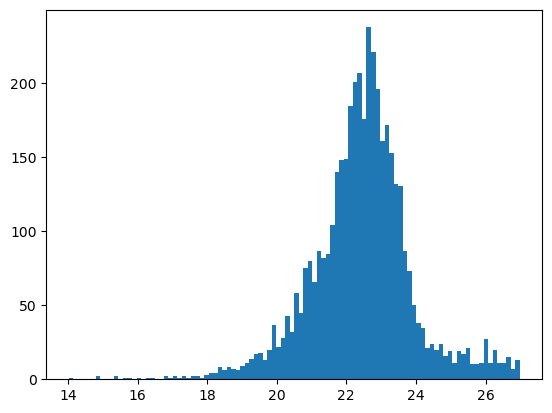

len(objects)=7


In [7]:
# select objects to plot
import matplotlib.pyplot as plt
fluxes = [joined[f"refcat_flux_{band}"] for band in "ugrizy"]
flux_ref = np.sum(fluxes, axis=0)
mag = u.nJy.to(u.ABmag, flux_ref)

plt.hist(mag, bins=100)
plt.show()

stars_bright = np.where((joined["refcat_is_pointsource"] & (mag > 17) & (mag < 18)))[0]
objectIds = joined["objectId"][stars_bright]
objects = [catalog_multi.find(obj) for obj in objectIds]
objects = [catalog_multi.find(obj["parent"]) if obj["parent"] else obj for obj in objects]
print(f"{len(objects)=}")


key='mpf' parent['id']=3458764513820541275


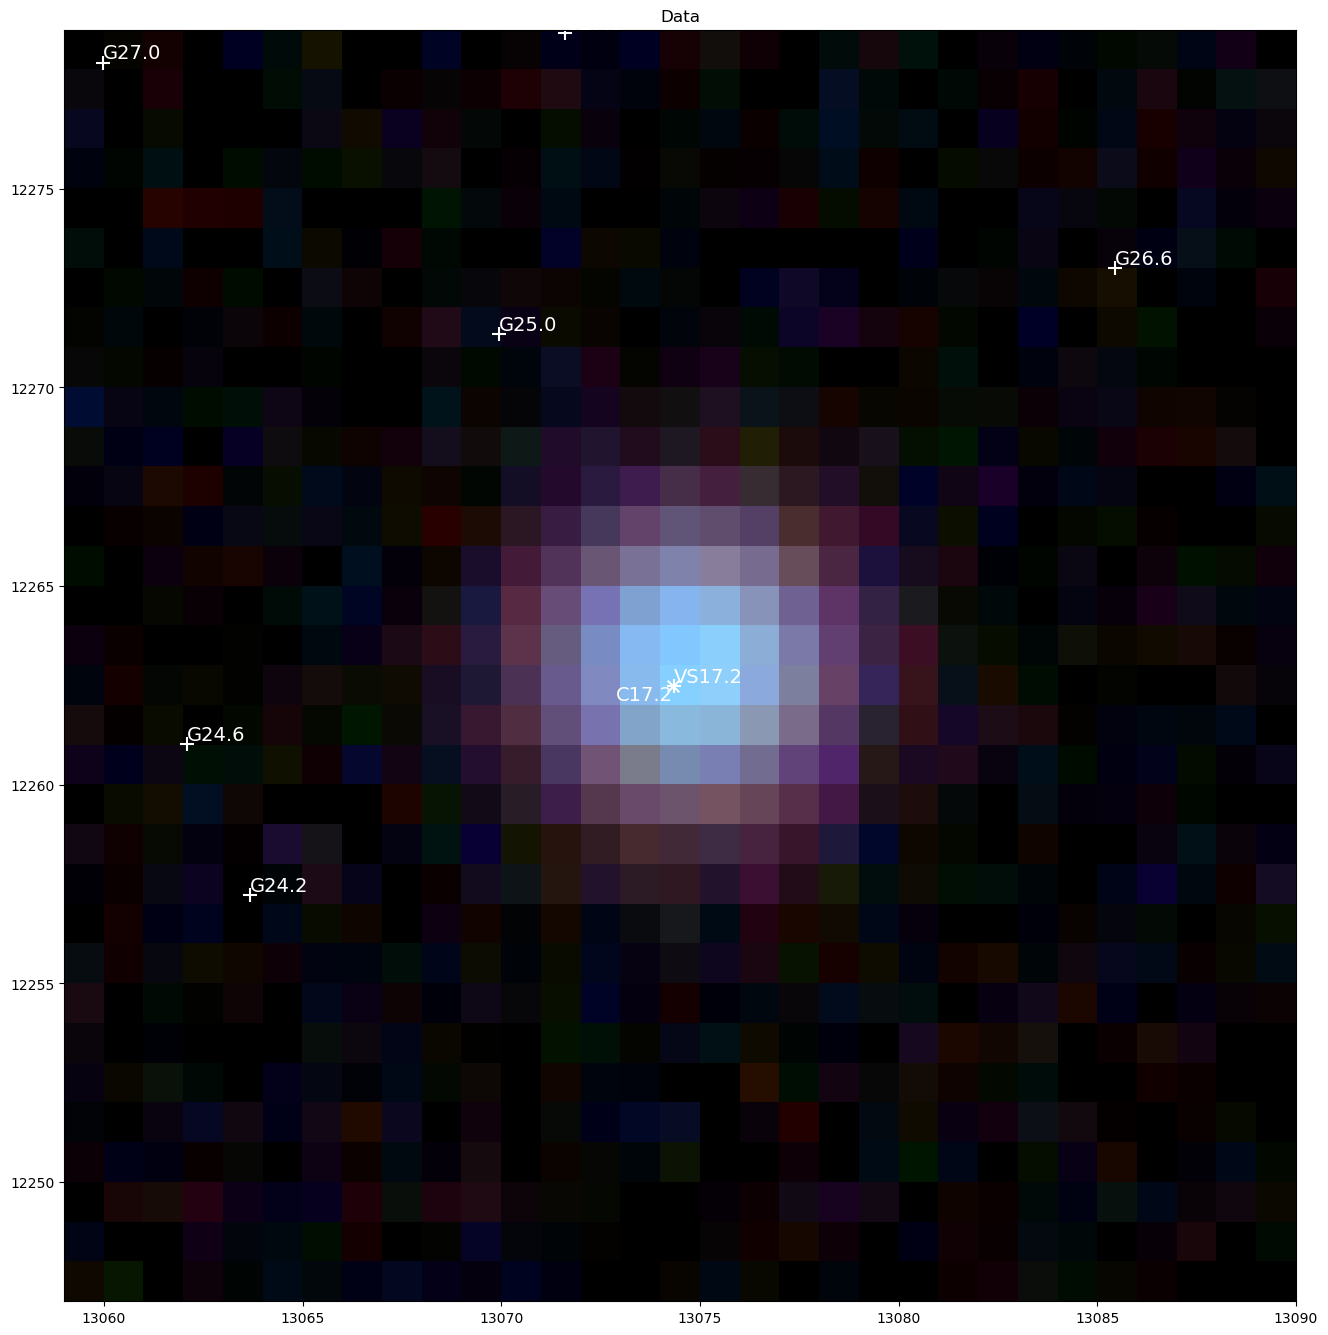

Model: cModel
Model: ser


/sdf/data/rubin/user/dtaranu/tickets/DM-43357/multiprofit/python/lsst/multiprofit/plots.py:540: RuntimeWarning: divide by zero encountered in power
  variance_band = observation.sigma_inv.data ** -2


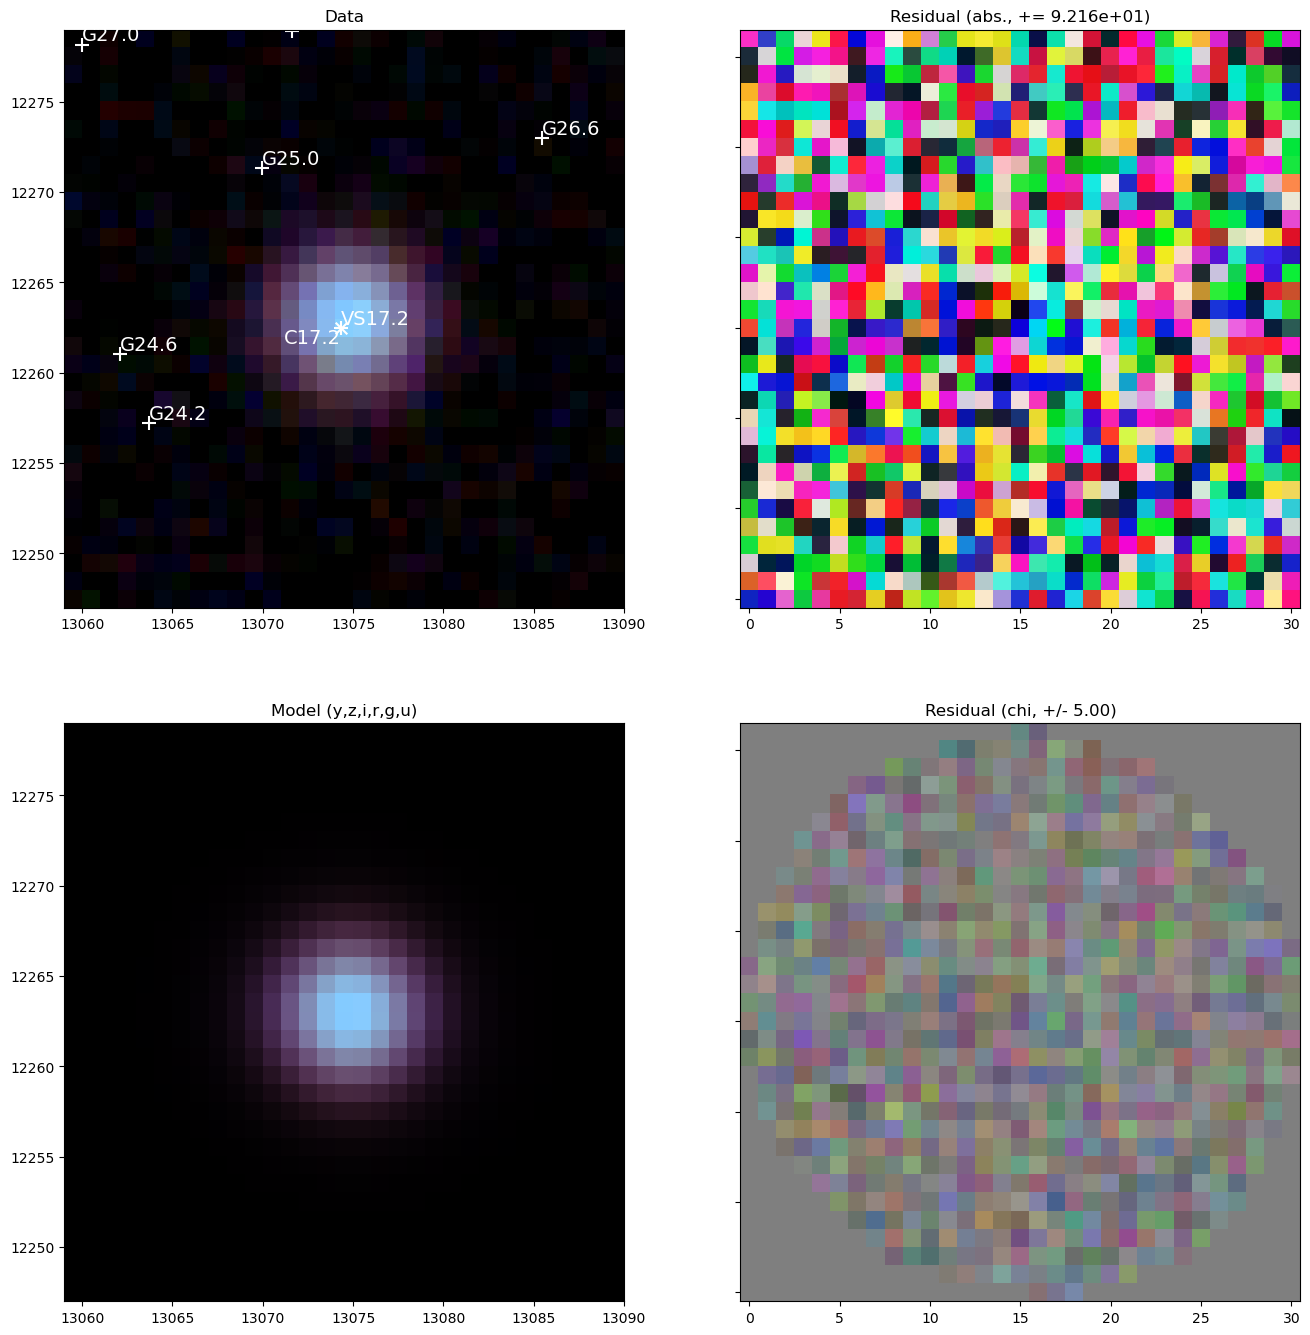

key='shapelet' parent['id']=3458764513820541275


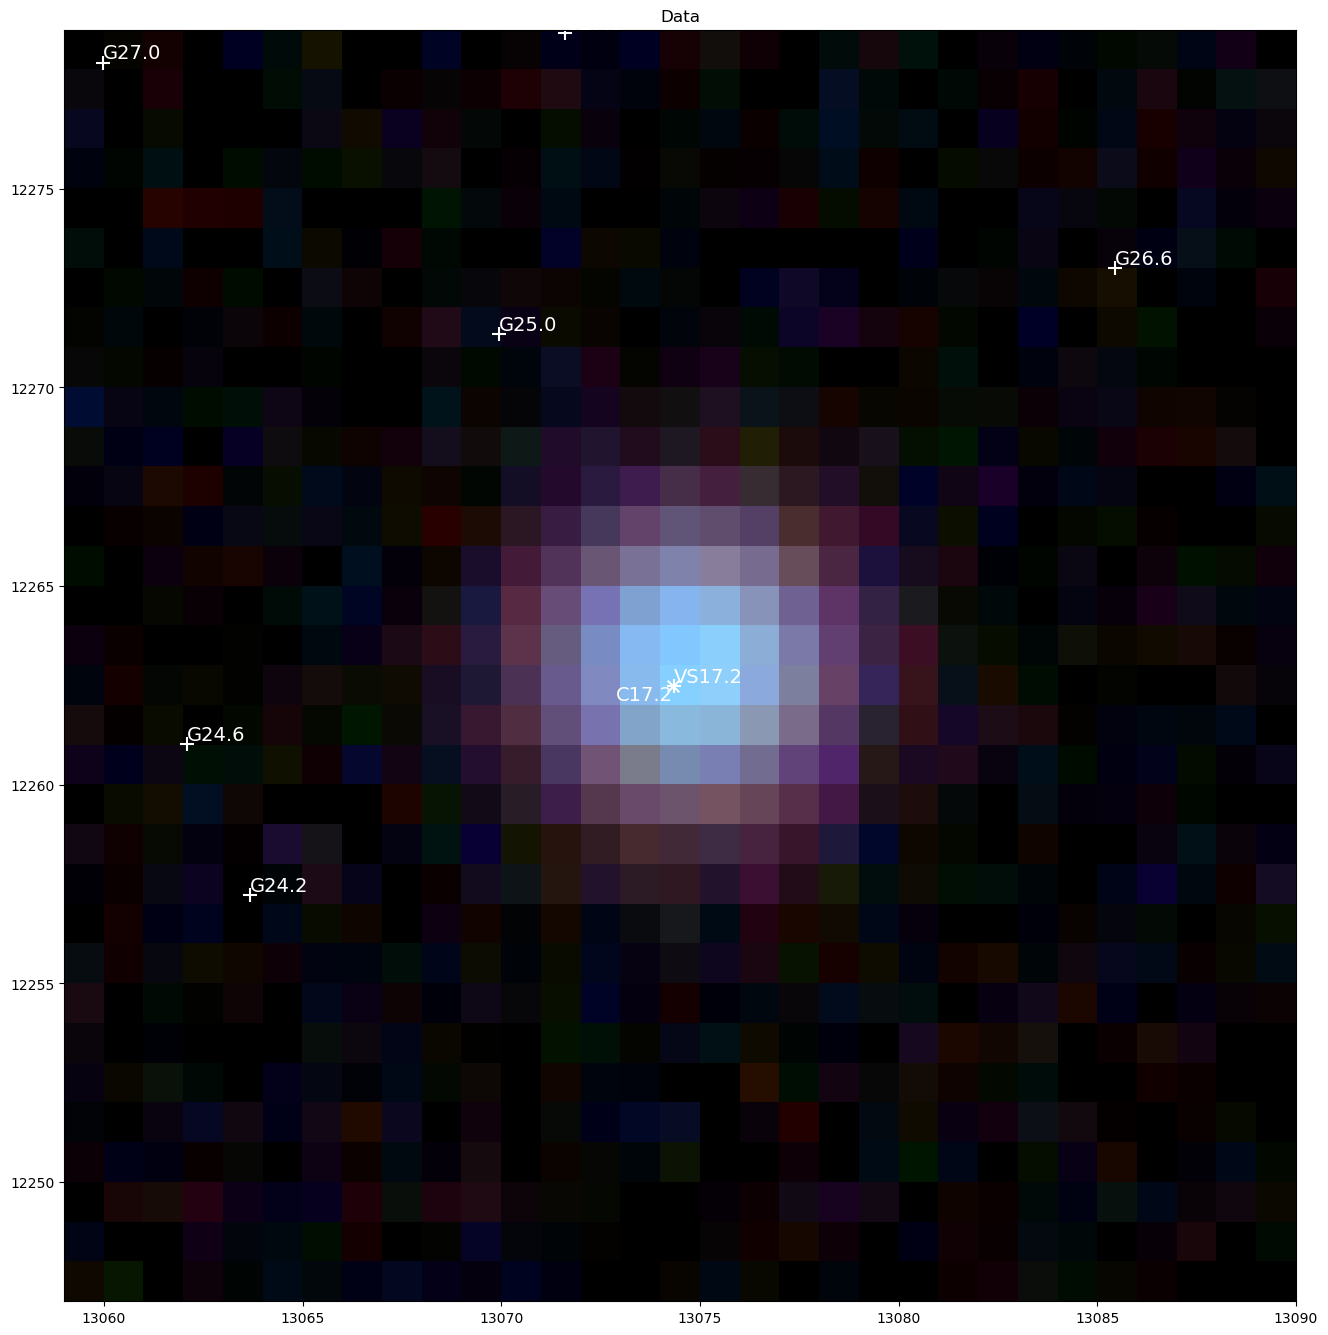

Model: cModel
Model: ser


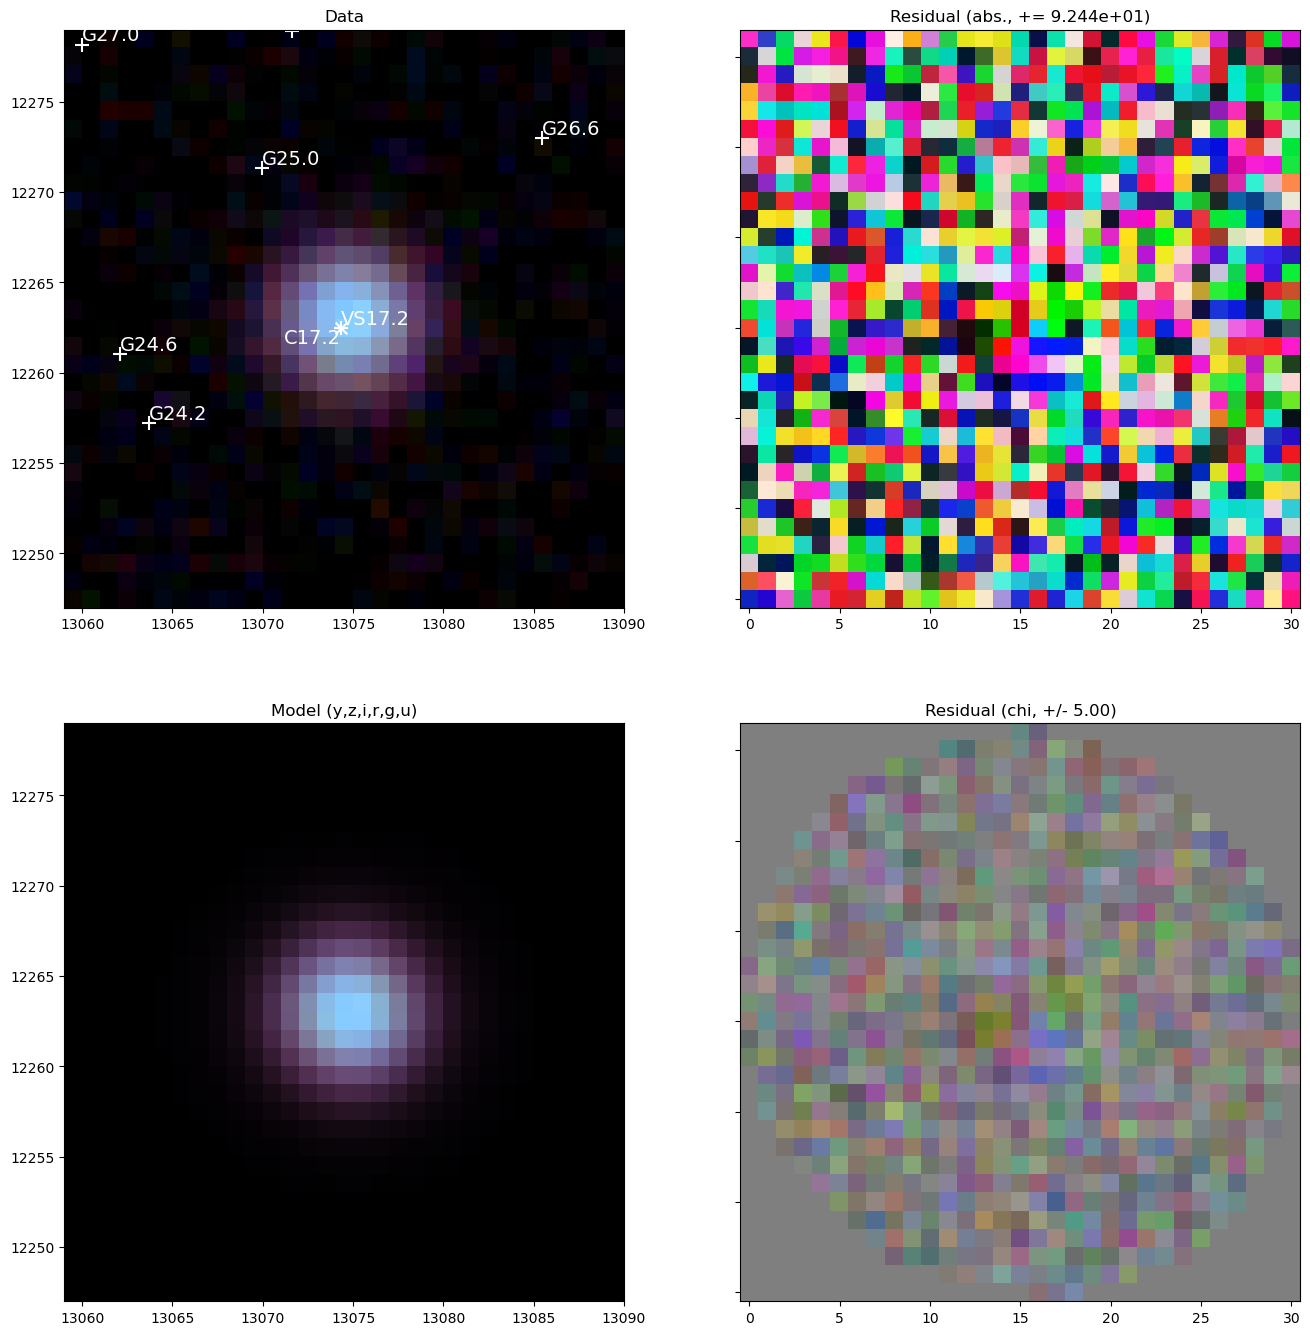

In [9]:
# plot some stars
for parent in objects[:1]:
    row_parent = np.where(catalog_multi["id"] == parent["id"])[0][0]
    for key, rebuilder in rebuilders.items():
        print(f"{key=} {parent['id']=}")
        fig_rgb, ax_rgb, fig_gs, ax_gs = plot_blend(rebuilder, row_parent, kwargs_plot_parent=kwargs_parent, kwargs_plot_children=kwargs_children)